### Import model and data

In [1]:
from tensorflow.keras.models import load_model
import numpy as np

model_path = "../models/EfficientNetv2.h5"
model = load_model(model_path)

2023-03-07 21:49:17.538848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 21:49:22.728038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16

In [3]:
train_data_dir = '../raw_data/Training/'
test_data_dir = '../raw_data/Testing/'


train_ds, val_ds = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  validation_split = 0.2,
  subset="both",
  color_mode = 'rgb',
  batch_size= 40)

# We define a second one for the test data

test_ds = image_dataset_from_directory(
  test_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  color_mode = 'rgb',
  batch_size= 40)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [4]:
# base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (255, 255, 3))
# model = Sequential()
# model.add(layers.Input(shape = (255, 255, 3)))
# model.add(base_model)
# model.add(layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(16, activation = 'relu'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(4, activation='softmax'))
# base_model.trainable = False

# adam = optimizers.Adam(learning_rate = 0.001)
# model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])

# history = model.fit(
#         train_ds,
#         batch_size=64,
#         epochs=1)

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 8, 8, 1536)       12930622  
 al)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          221200    
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                      

In [6]:
def get_image_from_dataset (dataset, batch_num, image_num):
    for images, labels in dataset.take(batch_num):
        numpy_image = images.numpy()[image_num]/255
        numpy_label = labels.numpy()[image_num]
    
    return (numpy_image, numpy_label)

In [7]:
def get_images_from_dataset (dataset, batch_num):
    for images, labels in dataset.take(batch_num):
        numpy_images = images.numpy()/255
        numpy_labels = labels.numpy()
    
    return (numpy_images, numpy_labels)

In [8]:
data = get_images_from_dataset(test_ds,2)
datapoint = get_image_from_dataset(train_ds, 40, 3)
datapoint = (np.expand_dims(datapoint[0], axis=0), np.expand_dims(datapoint[1], axis=0))

In [9]:
# # Load a sample image (or multiple ones)
# IMAGE_PATH = '/Users/victorvoneisenhart-rothe/code/Victorvone/braintumorclassification/braintumorclassification/raw_data/Testing/glioma/Te-gl_0010.jpg'\
    
# img = load_img(IMAGE_PATH, target_size=(255, 255))
# img = img_to_array(img)/255
# datapoint = ([img], 0)
# # plt.imshow(img)

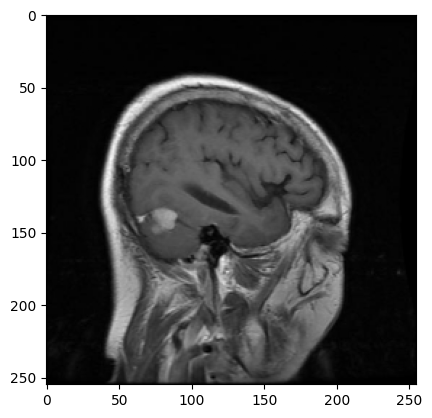

In [10]:
plt.imshow(datapoint[0][0,:,:,:])

In [11]:
np.array(datapoint[0]).shape

(1, 255, 255, 3)

In [12]:
# print(datapoint[1])
np.round(model.predict(datapoint[0]),3)

1/1 [==============================] - 4s 4s/step


array([[0.   , 0.997, 0.   , 0.003]], dtype=float32)

In [14]:
model.evaluate(test_ds)

11/33 [=========>....................] - ETA: 40s - loss: 0.0713 - accuracy: 0.9727

KeyboardInterrupt: 

### Activation visualization

In [ ]:
from tf_explain.core.activations import ExtractActivations

ActViz = ExtractActivations()
grid = ActViz.explain(datapoint, model, layers_name='conv2d_1')
ActViz.save(grid, "../Visualizations/", "ActViz.png")

1/1 [==============================] - 3s 3s/step


### GradCam

In [ ]:
from tf_explain.core.grad_cam import GradCAM

#Start explainer
gradcam = GradCAM()
grid = gradcam.explain(datapoint, model, class_index=1) 

gradcam.save(grid, "../Visualizations/", "grad_cam.png")

### VanillaGradients

In [ ]:
from tf_explain.core.vanilla_gradients import VanillaGradients

Vanillagrad = VanillaGradients()
grid = Vanillagrad.explain(datapoint, model, class_index=0) 

Vanillagrad.save(grid, "../Visualizations/", "VanillaGradient.png")

/var/folders/yg/kt4pdk955453dzxyb3ppm5200000gn/T/ipykernel_18926/259031334.py:4: UserWarning: Unsupported model architecture for VanillaGradients. The last two layers of the model should be: a layer which computes class scores with no activation, followed by an activation layer.
  grid = Vanillagrad.explain(datapoint, model, class_index=0)


### Occlusion sensitivity map

In [ ]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

#Start explainer
occsens = OcclusionSensitivity()
grid = occsens.explain(datapoint, model, class_index=0, patch_size=8) 

occsens.save(grid, "../Visualizations/", "OcclusionSensitivity.png")

32/32 [==============================] - 51s 2s/step
